In [4]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

from collections import Counter, defaultdict

import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [5]:

import seaborn as sns
# sns.set()
sns.set_style("whitegrid")

In [6]:
import debias

In [15]:
in_dir = '/home/sssub/classimb_fairness-hiddenreps/datasets/deepmoji/'
proj_dir = '/home/sssub/classimb_fairness-hiddenreps/datasets/deepmoji/projection/'

import pickle
with open(in_dir+'train_with_hidden.pickle', 'rb') as f:
    train_data = pickle.load(f)

with open(in_dir+'dev_with_hidden.pickle', 'rb') as f:
    dev_data = pickle.load(f)

with open(in_dir+'test_with_hidden.pickle', 'rb') as f:
    test_data = pickle.load(f)

x_train, y_p_train, y_m_train = train_data['hidden'], train_data['protected_attribute'], train_data['labels']
x_dev, y_p_dev, y_m_dev = dev_data['hidden'], dev_data['protected_attribute'], dev_data['labels']
x_test, y_p_test, y_m_test = test_data['hidden'], test_data['protected_attribute'], test_data['labels']

all_Ps = np.load(proj_dir+'P_svm.num-clfs=300.npy', allow_pickle=True)
rowspaces = all_Ps[1]

In [9]:
from tqdm import tqdm_notebook as tqdm

In [17]:
len(rowspaces), rowspaces[0].shape

(47, (300, 300))

In [11]:
def get_TPR(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def group_evaluation(preds, labels, p_labels, silence=True):

    preds = np.array(preds)
    labels = np.array(labels)
    p_labels = np.array(p_labels)

    p_set = set(p_labels)
    if len(p_set)!=2:
        print("Assuming binary private labels")

    g1_preds = preds[np.array(p_labels) == 1]
    g1_labels = labels[np.array(p_labels) == 1]

    g0_preds = preds[np.array(p_labels) == 0]
    g0_labels = labels[np.array(p_labels) == 0]

    tn0, fp0, fn0, tp0 = confusion_matrix(g0_labels, g0_preds).ravel()
    TPR0 = tp0/(fn0+tp0)
    TNR0 = tn0/(fp0+tn0)

    tn1, fp1, fn1, tp1 = confusion_matrix(g1_labels, g1_preds).ravel()
    TPR1 = tp1/(fn1+tp1)
    TNR1 = tn1/(tn1+fp1)
    
    f1_0 = f1_score(g0_labels, g0_preds, average='macro')
    f1_1 = f1_score(g1_labels, g1_preds, average='macro')

    if not silence:
        print("F1 0: {}".format(f1_0))
        print("F1 1: {}".format(f1_1))

        print("TPR 0: {}".format(TPR0))
        print("TPR 1: {}".format(TPR1))

        print("TNR 0: {}".format(TNR0))
        print("TNR 1: {}".format(TNR1))

        print("TPR gap: {}".format(  (TPR0-TPR1)))
        print("TNR gap: {}".format(abs(TNR0-TNR1)))

    return {"F1_0": f1_0,
            "F1_1": f1_1,
            "TPR_0":TPR0,
            "TPR_1":TPR1,
            "TNR_0":TNR0,
            "TNR_1":TNR1,
            "TPR_gap":abs(TPR0-TPR1),
            "TNR_gap":abs(TNR0-TNR1),
            "F1 GAP": abs(f1_0-f1_1)}

In [26]:
def rms(arr):
    return np.sqrt(np.mean(np.square(arr)))

In [41]:
ratio_tradeoff = defaultdict(dict)

for p_iteration in tqdm(range(0, len(rowspaces))):
    
    P = debias.get_projection_to_intersection_of_nullspaces(rowspaces[:p_iteration], input_dim=300)
    
    debiased_x_train = P.dot(x_train.T).T
    debiased_x_dev = P.dot(x_dev.T).T
    
    classifier = LogisticRegression(random_state=0)

    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_dev, y_m_dev)
    
    _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)
    preds = classifier.predict(debiased_x_dev)
    out = group_evaluation(preds, y_m_dev, y_p_dev)
    ratio_tradeoff[p_iteration]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))
    ratio_tradeoff[p_iteration]['debiased_acc'] = f1_score(preds, y_m_dev, average='macro')
    ratio_tradeoff[p_iteration]['debiased_diff_f1'] = out['F1 GAP']

<ipython-input-41-42fa1f9f55c2>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p_iteration in tqdm(range(0, len(rowspaces))):


/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


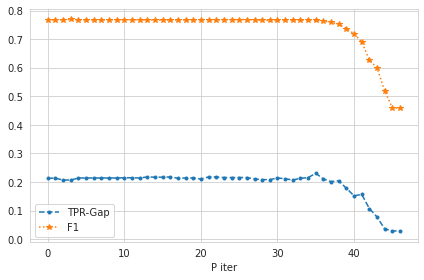

In [42]:
def data2plot(x, y1, y2, x_label=None, y_label=None, title=None):

    # label is optional, and is used for the legend
    # here, the third arguemtns are a mix of the `marker' and the `linestyle'
    ax = plt.plot(x, y1, '.--', label='TPR-Gap')
    ax = plt.plot(x, y2, '*:', label='F1')

    if y_label:
        plt.ylabel(y_label)
    if x_label:
        plt.xlabel(x_label)
    if title:
        plt.title(title)

    # Optional (and many times useful)
    # plt.ylim(0.5,0.90)
    plt.legend(loc='lower left', frameon=True)
    
    plt.tight_layout()
    #plt.savefig('acc_tpr.pdf', dpi=1000)
    plt.show()
    
data2plot(list(ratio_tradeoff.keys()),
          [x['debiased_diff_tpr'] for x in ratio_tradeoff.values()],
          [x['debiased_acc'] for x in ratio_tradeoff.values()], 'P iter', title='')

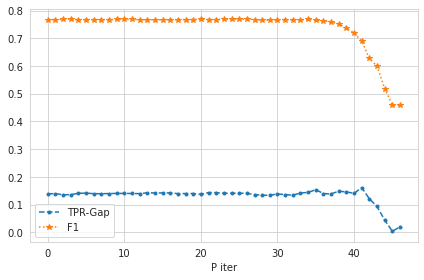

In [43]:
data2plot(list(ratio_tradeoff.keys()),
          [x['debiased_diff_f1'] for x in ratio_tradeoff.values()],
          [x['debiased_acc'] for x in ratio_tradeoff.values()], 'P iter', title='')

In [38]:
ratio_tradeoff

defaultdict(dict,
            {0: {'debiased_diff_tpr': 0.21327566555908403,
              'debiased_acc': 0.7668121480762464,
              'debiased_diff_f1': 0.13897208696812524},
             1: {'debiased_diff_tpr': 0.21322280381123596,
              'debiased_acc': 0.7673710181863999,
              'debiased_diff_f1': 0.13966325518003553},
             2: {'debiased_diff_tpr': 0.20679459092812333,
              'debiased_acc': 0.7680863097788404,
              'debiased_diff_f1': 0.1352159514402279},
             3: {'debiased_diff_tpr': 0.2067467777496354,
              'debiased_acc': 0.7686457299606086,
              'debiased_diff_f1': 0.13590772205307344},
             4: {'debiased_diff_tpr': 0.21394445795944075,
              'debiased_acc': 0.7669578459107476,
              'debiased_diff_f1': 0.14083813858580652},
             5: {'debiased_diff_tpr': 0.21392047524237262,
              'debiased_acc': 0.7672371803713276,
              'debiased_diff_f1': 0.14118374480465

In [36]:
for iter_val in range(38, 44):
    P = debias.get_projection_to_intersection_of_nullspaces(rowspaces[:iter_val], input_dim=300)
    debiased_x_train = P.dot(x_train.T).T
    debiased_x_test = P.dot(x_test.T).T
    classifier = LogisticRegression(random_state=0)
    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_test, y_m_test)
    _, debiased_diffs = get_TPR(y_m_test, classifier.predict(debiased_x_test), y_p_test)
    preds = classifier.predict(debiased_x_test)
    out = group_evaluation(preds, y_m_test, y_p_test)
    f1 = f1_score(preds, y_m_test, average='macro')
    tpr = rms(list(debiased_diffs.values()))
    f1_gap = out['F1 GAP']
    print (iter_val, f1, tpr, f1_gap)

38 0.764813128894105 0.1426729166069425 0.10534614146463861
39 0.7494395536850187 0.11400913361445021 0.09209890529794618
40 0.7312723848849894 0.11902576708432176 0.11066075405672593


/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


41 0.7040178571428571 0.08228621769134815 0.08646697059519526


/home/sssub/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


42 0.6392843934911242 0.0655391474932123 0.07642486374789303
43 0.6070670850141939 0.05869714819427734 0.06966989184016481
